# Detección de anomalías

## Autores:
* Pedro Hernández
* Aaron Lara
* Benjamin López

En esta libreta de Jupyter se realizará una detección de anomalías mediante tres métodos diferentes para comparar los resultados de cada uno. Los algoritmos que se probarán son: *Método 1*, *Método 2* y *Método 3*.

El conjunto de datos sobre el que se trabajará fue extraído de la [base de datos climatológica nacional (sistema CLICOM)](http://clicom-mex.cicese.mx/) donde se recopilan los datos de las estaciones climáticas superficiales de México. En esta ocasión, se trabajará específicamente sobre las lecturas climatológicas realizadas en las estaciones del estado de Sonora desde 1960 hasta 2019.


## Importación de las Librerías

In [1]:
# Para el manejo eficiente del conjunto de datos
import pandas as pd 
import numpy as np
from scipy import stats
# Para construir los elementos gráficos
import seaborn as sns 
import matplotlib.pyplot as plt
# Para la visualización de los valores nulos
import missingno as msno
from sklearn.neighbors import LocalOutlierFactor

## Extracción de los datos

El sistema CLICOM carece de una API para la extracción de sus datos. Por este motivo se han descargado manualmente los archivos csv correspondientes a cada variable y a cada estación climatológica del estado de Sonora. Los csvs originales se encuentran comprimidos en el archivo [datos/clicom_mex_cicese_sonora.zip]().

Para unir todos los datos en un solo archivo se construyó el script [joinData.py](). Este programa une y comprime los datos; el resultado se encuentra almacenado en el archivo [datos/datos_sonora.zip]()

## Limpieza de datos

### Se cargan los datos desde el archivo comprimido

In [2]:
df = pd.read_csv("datos/datos_hermosillo.zip", low_memory=False)

In [26]:
df.head(3)

,Fecha,IdEstacion,NombreEstacion,CoordGeoEstacion,Temp Mínima (oC),Temp Máxima (oC),Temp Promedio (oC),Unidades Calor (oD),Evaporación (mm),Precipitación (mm)
0,1974-07-01,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,22.0,35.0,28.50,17.13,7.3,0.0
1,1974-07-02,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,22.5,34.0,28.25,17.21,10.5,0.0
2,1974-07-03,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,21.0,31.5,26.25,16.01,13.6,0.0


In [27]:
df.tail(3)

,Fecha,IdEstacion,NombreEstacion,CoordGeoEstacion,Temp Mínima (oC),Temp Máxima (oC),Temp Promedio (oC),Unidades Calor (oD),Evaporación (mm),Precipitación (mm)
49671,2016-09-28,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,22.0,35.0,NaN,17.13,NaN,0.0
49672,2016-09-29,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,24.0,37.5,NaN,18.21,NaN,0.0
49673,2016-09-30,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,24.5,37.0,NaN,18.37,NaN,0.0


In [28]:
print("Número de renglones y columnas:", df.shape)

Número de renglones y columnas: (49674, 10)


### Ajuste de los tipos de datos y nombres de las variables

In [29]:
df.dtypes

Fecha                   object
IdEstacion               int64
NombreEstacion          object
CoordGeoEstacion        object
Temp Mínima (oC)       float64
Temp Máxima (oC)       float64
Temp Promedio (oC)     float64
Unidades Calor (oD)    float64
Evaporación (mm)       float64
Precipitación (mm)     float64
dtype: object

Como podemos observar, Pandas toma la fecha como una variable tipo `object` (`str`). Además, los nombres de las columnas contienen las unidades pero podemos prescindir de éstas. Necesitamos corregir estos detalles para manejar los datos de manera adecuada.

In [3]:
# Renombrando las columnas
nuevas_columnas = {'NombreEstacion':'Estacion', 'Temp Mínima (oC)':'Tmin', 'Temp Máxima (oC)':'Tmax', 
                   'Temp Promedio (oC)':'Tprom', 'Unidades Calor (oD)':'UCalor', 
                   'Evaporación (mm)':'Evap', 'Precipitación (mm)':'Precip'
                  }
df.rename(columns=nuevas_columnas, inplace=True)

In [4]:
# Corrección del tipo de datos de la fecha
df.Fecha = pd.to_datetime(df.Fecha)

In [ ]:
# Verificación de los cambios
df.dtypes

In [81]:
df.describe()

,IdEstacion,Tmin,Tmax,Tprom,UCalor,Evap,Precip
count,49674.000000,49674.000000,49674.000000,49674.000000,49674.000000,49674.000000,49674.000000
mean,26155.521540,13.381380,26.103782,7.065466,10.535437,3.815220,0.681650
std,19.302324,8.751038,13.090010,10.804209,6.595957,4.315742,4.505532
min,26138.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26139.000000,7.000000,22.000000,0.000000,5.362750,0.000000,0.000000
50%,26139.000000,13.000000,29.500000,0.000000,11.030000,2.465000,0.000000
75%,26179.000000,21.000000,36.000000,16.000000,16.880000,7.100000,0.000000
max,26179.000000,32.000000,49.000000,37.250000,20.000000,18.000000,152.600000


### Revisión de valores faltantes

In [33]:
df.isnull().sum()

Fecha                   0
IdEstacion              0
Estacion                0
CoordGeoEstacion        0
Tmin                 9841
Tmax                 9835
Tprom               35461
UCalor              10251
Evap                24660
Precip               9410
dtype: int64

Podemos notar que existen muchos valores faltantes. Algunas gráficas y porcentajes nos ayudarán a darnos una mejor idea del comportamiento de los datos nulos

<AxesSubplot:>

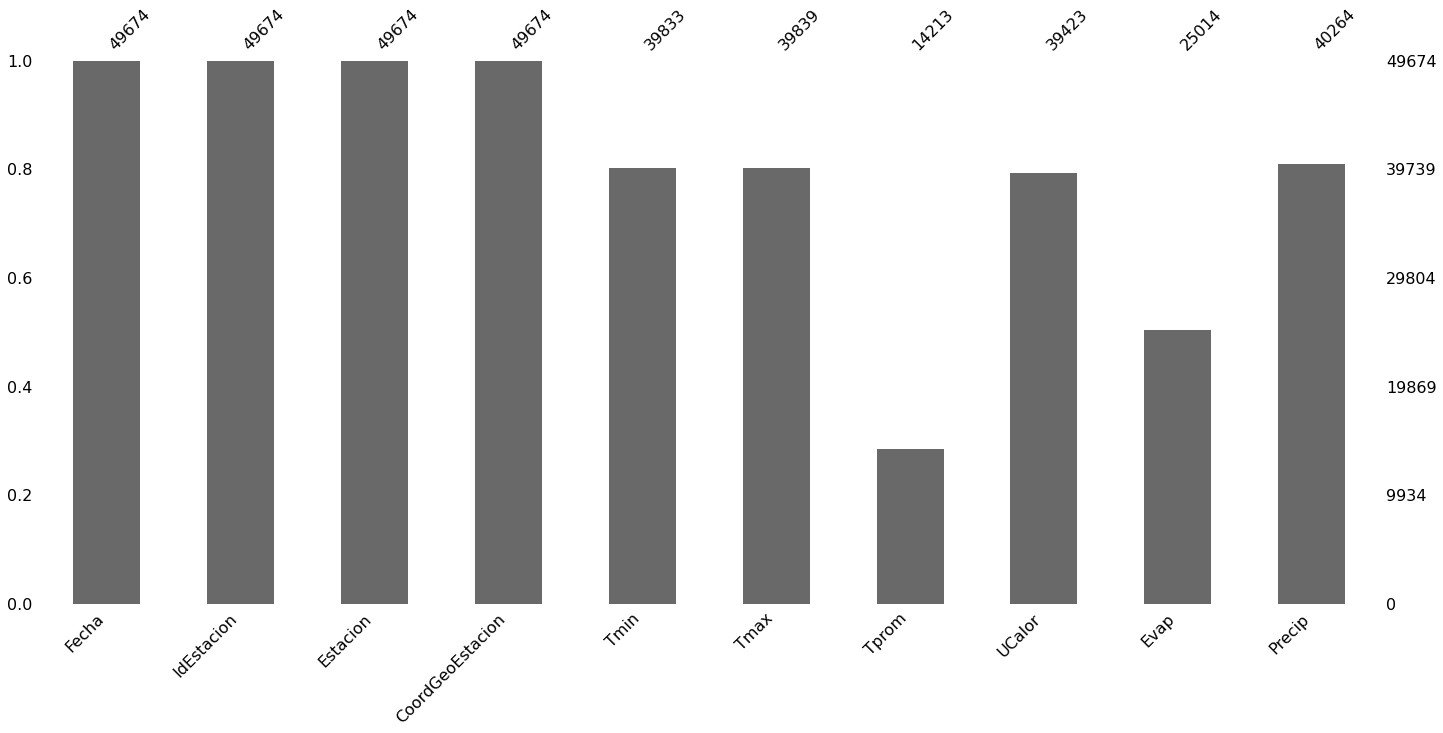

In [34]:
msno.bar(df)

<AxesSubplot:>

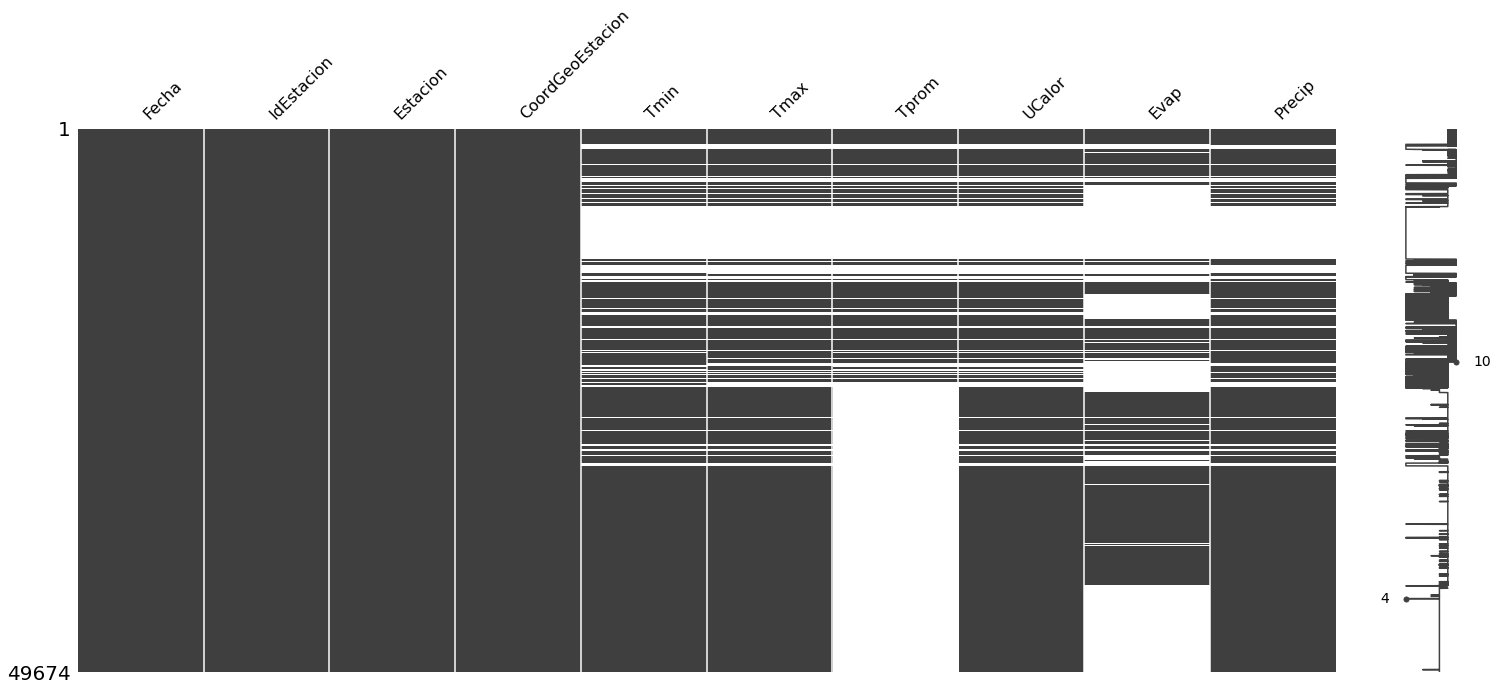

In [35]:
msno.matrix(df)

In [5]:
print("Porcentaje de valores nulos por columna\n")
total_rows = len(df)
for c in df.columns:
    num_nans = df[c].isna().sum()
    print(f"{c}: {num_nans} -> ({str(num_nans/total_rows*100)[:5]}%)")

Porcentaje de valores nulos por columna

Fecha: 0 -> (0.0%)
IdEstacion: 0 -> (0.0%)
Estacion: 0 -> (0.0%)
CoordGeoEstacion: 0 -> (0.0%)
Tmin: 9841 -> (19.81%)
Tmax: 9835 -> (19.79%)
Tprom: 35461 -> (71.38%)
UCalor: 10251 -> (20.63%)
Evap: 24660 -> (49.64%)
Precip: 9410 -> (18.94%)


Todas las variables de interés (desde `Tmin` hasta `Precip`) tienen un alto porcentaje de valores nulos, por este motivo sería buena idea realizar imputaciones. 

Podemos realizar las imputaciones utilizando alguna medida de tendencia central (mediana o promedio) basándonos en las temperaturas observadas en una determinada región y un periodo de tiempo. Por ejemplo, las temperaturas mínimas en los meses de invierno son mucho más bajas que en los meses de verano; a su vez, las temperaturas, precipitaciones y evaporación al norte del estado son considerablemente diferentes a las del sur.

Para cumplir este objetivo se utilizará el siguiente algoritmo:
* Por cada año, mes y municipio:
    * Por cada variable con datos nulos:
        * Realizar una prueba de hipótesis para saber si la distribución de la 
          variable se asemeja a una distribución normal
        * Si la distribución se parece a una normal ($p-valor<=0.05$), imputar con el valor promedio
        * Si la distribución no se parece a una normal ($p-valor>0.05$), imputar con la mediana
            


#### Imputación de los valores nulos

Para identificar más fácilmente los municipios a los que pertenece cada estación, el nombre de éste se añadirá a cada observación en una columna nueva

In [6]:
df['Municipio'] = df.Estacion.apply(lambda estacion: estacion.split('-')[0])
df

,Fecha,IdEstacion,Estacion,CoordGeoEstacion,Tmin,Tmax,Tprom,UCalor,Evap,Precip,Municipio
0,1974-07-01,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,22.0,35.0,28.50,17.13,7.3,0.0,BAHIA DE KINO
1,1974-07-02,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,22.5,34.0,28.25,17.21,10.5,0.0,BAHIA DE KINO
2,1974-07-03,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,21.0,31.5,26.25,16.01,13.6,0.0,BAHIA DE KINO
3,1974-07-04,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,28.0,41.0,34.50,19.66,10.7,0.0,BAHIA DE KINO
4,1974-07-05,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,28.0,35.0,31.50,19.53,10.9,0.0,BAHIA DE KINO
...,...,...,...,...,...,...,...,...,...,...,...
49669,2016-09-26,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,24.0,36.0,NaN,18.09,NaN,5.2,HERMOSILLO II (DGE)
49670,2016-09-27,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,21.0,35.5,NaN,16.75,NaN,0.0,HERMOSILLO II (DGE)
49671,2016-09-28,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,22.0,35.0,NaN,17.13,NaN,0.0,HERMOSILLO II (DGE)
49672,2016-09-29,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,24.0,37.5,NaN,18.21,NaN,0.0,HERMOSILLO II (DGE)


#### ---------- NOTA IMPORTANTE ----------

El algoritmo de imputación es considerablemente costoso por lo que su tiempo de ejecución es de aproximadamente una hora. 
Los datos imputados ya se han calculado y están almacenados en el archivo `datos/datos_sonora_no_nans.zip`. Si deseas omitir
este procedimiento continúa a partir de la siguiente sección *"Análisis exploratorio de datos"*

In [7]:
# En este objeto grouby se almacenarán los "sub-dataframes" agrupados por año, mes y municipio
df_agrupado = df.groupby([df.Fecha.dt.year, df.Fecha.dt.month, 'Municipio'])

In [8]:
# Se importan las dependencias necesarias para realizar la prueba de hipótesis
from scipy.stats import skewtest
import math
# Se obtiene la cantidad de grupo s (año,mes,municipio)
n_groups = len(df_agrupado.indices.keys())
n_groups
i = 0 # Contador para saber cuánto le falta al proceso para terminar

# ----- COMIENZA EL ALGORITMO DE IMPUTACIÓN -----
# Cada elemento 'k' representa la lista de renglones correspondientes a cada grupo
for k in df_agrupado.indices.keys():
    # Se obtienen los índices correspondientes al grupo actual
    indices = df_agrupado.indices[k]
    # Se itera cada variable numérica para realizar la imputación
    # (4:Tmin, 5:Tmax, 6:Tprom, 7:UCalor, 8:Evap, 9:Precip)
    for column in [4,5,6,7,8,9]:
        # Se obtiene la porción del dataframe que corresponde al grupo y columna actual
        df_group = df.iloc[indices,column]
        # Primero se revisa si existen valores nulos en el grupo y columna que está 
        # siento revisada
        if df_group.isnull().values.any():
            # Si existen valores nulos se realiza un skew test para saber
            # si hay que imputar con la mediana o con la media.
            
            # En ocasiones las variables llegan a presentar valores nulos
            # en un mes completo. En este caso no tendríamos cómo
            # calcular una imputación, así que se imputará directamente con 0.
            # La necesidad del try-except radica en que para la prueba de hipótesis
            # necesita al menos 8 valores no nulos para poder calcular algo
            try:
                # Se obtiene el p-valor de la prueba de hipótesis
                pvalue = skewtest(df_group, nan_policy='omit')[1]
            except:
                # Si no se pudo realizar la prueba de hipótesis significa que la 
                # variable en cuestión presentó valores nulos por lo menos 22 días al mes.
                # (el método skewtest debe recibir por lo menos 8 valores).
                # En este caso se intenta imputar con la media. Si la media es nan, entonces
                # significa que no existen valores diferentes de nan en el mes completo. En ese
                # caso se imputa directamente con 0.
                mean = df_group.mean()
                if not math.isnan(mean):
                    df.iloc[indices, column] = df_group.fillna(mean)
                else:
                    df.iloc[indices, column] = df_group.fillna(0)
                continue
            
            # Si el pvalor es >.05 rechazamos la hipótesis de que los datos se 
            # distribuyen normalmente y se imputa con la mediana; en caso contrario, 
            # se imputa con la media
            if pvalue > .05:
                df.iloc[indices, column] = df_group.fillna(df_group.median())
            else:
                df.iloc[indices, column] = df_group.fillna(df_group.mean())
    i += 1
    print(f"{i}/{n_groups}",end='\r')
    

Revisemos que, en efecto, ya no existen valores nulos en nuestro conjunto de datos

In [9]:
df

,Fecha,IdEstacion,Estacion,CoordGeoEstacion,Tmin,Tmax,Tprom,UCalor,Evap,Precip,Municipio
0,1974-07-01,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,22.0,35.0,28.50,17.13,7.3,0.0,BAHIA DE KINO
1,1974-07-02,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,22.5,34.0,28.25,17.21,10.5,0.0,BAHIA DE KINO
2,1974-07-03,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,21.0,31.5,26.25,16.01,13.6,0.0,BAHIA DE KINO
3,1974-07-04,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,28.0,41.0,34.50,19.66,10.7,0.0,BAHIA DE KINO
4,1974-07-05,26179,BAHIA DE KINO-SON,28.8227777778N -111.948888889W,28.0,35.0,31.50,19.53,10.9,0.0,BAHIA DE KINO
...,...,...,...,...,...,...,...,...,...,...,...
49669,2016-09-26,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,24.0,36.0,0.00,18.09,0.0,5.2,HERMOSILLO II (DGE)
49670,2016-09-27,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,21.0,35.5,0.00,16.75,0.0,0.0,HERMOSILLO II (DGE)
49671,2016-09-28,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,22.0,35.0,0.00,17.13,0.0,0.0,HERMOSILLO II (DGE)
49672,2016-09-29,26139,HERMOSILLO II (DGE)-SON,29.0988888889N -110.965833333W,24.0,37.5,0.00,18.21,0.0,0.0,HERMOSILLO II (DGE)


<AxesSubplot:>

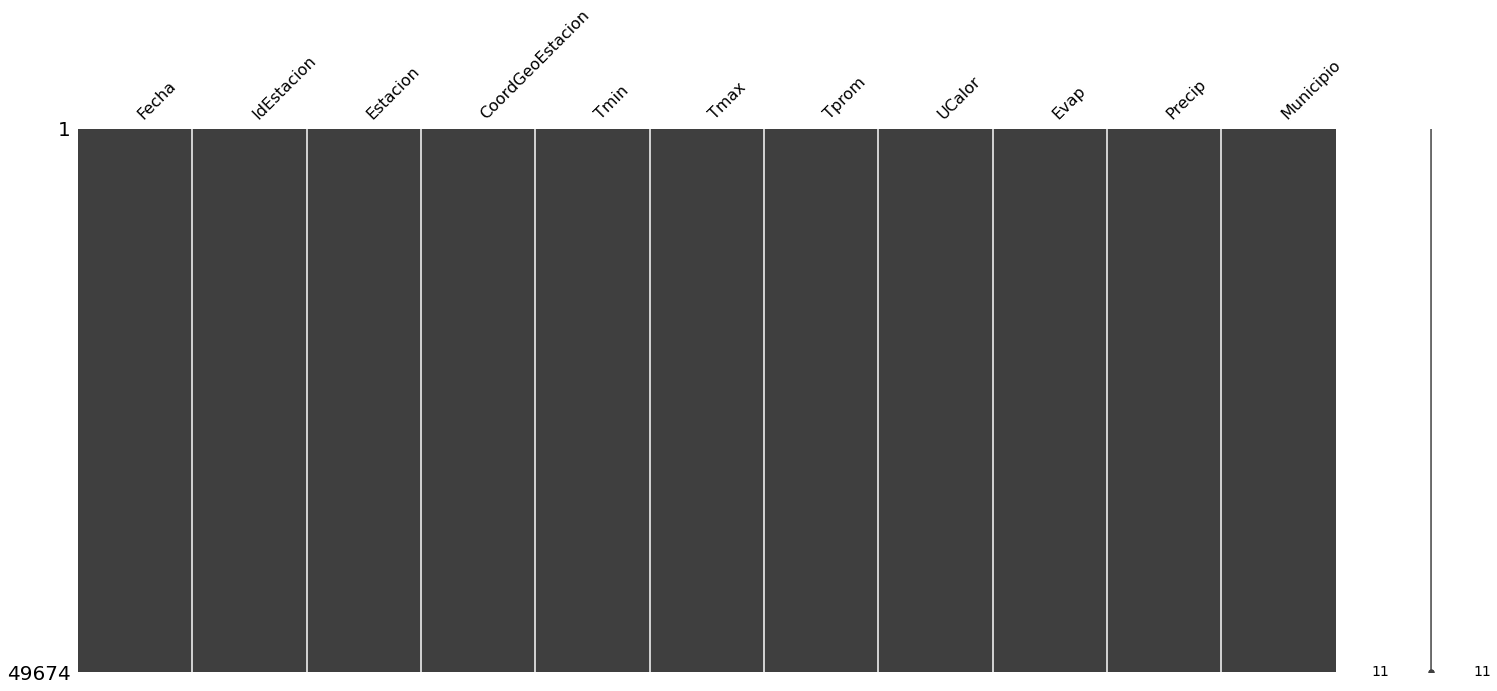

In [19]:
msno.matrix(df)

In [10]:
print("Porcentaje de valores nulos por columna\n")
total_rows = len(df)
for c in df.columns:
    num_nans = df[c].isna().sum()
    print(f"{c}: {num_nans} -> ({str(num_nans/total_rows*100)[:5]}%)")

Porcentaje de valores nulos por columna

Fecha: 0 -> (0.0%)
IdEstacion: 0 -> (0.0%)
Estacion: 0 -> (0.0%)
CoordGeoEstacion: 0 -> (0.0%)
Tmin: 0 -> (0.0%)
Tmax: 0 -> (0.0%)
Tprom: 0 -> (0.0%)
UCalor: 0 -> (0.0%)
Evap: 0 -> (0.0%)
Precip: 0 -> (0.0%)
Municipio: 0 -> (0.0%)


Debido a que el algoritmo de imputación es computacionalmente costoso se almacenarán los datos sin valores faltantes para que no sea necesario correr dicho algoritmo cada vez que la libreta se ejecute.

In [20]:
from zipfile import ZipFile, ZIP_DEFLATED
import os
# Se guarda el archivo de resultados
df.to_csv(f'datos/datos_sonora_no_nans.csv', index=False)
# Se comprimen los resultados
with ZipFile(f'datos/datos_sonora_no_nans.zip', 'w') as zip:
    zip.write(f'datos/datos_sonora_no_nans.csv', compress_type=ZIP_DEFLATED)
# Se elimina el csv
os.remove(f'datos/datos_sonora_no_nans.csv')

## Análisis exploratorio de datos

In [21]:
# Se lee el csv sin datos faltantes
df = pd.read_csv('datos/datos_sonora_no_nans.zip')

In [22]:
df.head()

,Fecha,IdEstacion,Estacion,CoordGeoEstacion,Tmin,Tmax,Tprom,UCalor,Evap,Precip,Municipio
0,1969-01-01,26041,QUITOVAC II-SON,31.5277777778N -112.728611111W,8.0,25.5,16.75,7.04,4.80,0.0,QUITOVAC II
1,1969-01-02,26041,QUITOVAC II-SON,31.5277777778N -112.728611111W,7.0,24.5,15.75,6.29,4.50,0.0,QUITOVAC II
2,1969-01-03,26041,QUITOVAC II-SON,31.5277777778N -112.728611111W,5.5,23.5,14.50,5.48,4.25,0.0,QUITOVAC II
3,1969-01-04,26041,QUITOVAC II-SON,31.5277777778N -112.728611111W,10.0,23.0,16.50,6.50,5.10,0.0,QUITOVAC II
4,1969-01-05,26041,QUITOVAC II-SON,31.5277777778N -112.728611111W,9.0,24.0,16.50,6.61,4.65,0.0,QUITOVAC II


In [23]:
df.tail()

,Fecha,IdEstacion,Estacion,CoordGeoEstacion,Tmin,Tmax,Tprom,UCalor,Evap,Precip,Municipio
3270287,2008-04-28,26087,SAN LUIS RIO COLORADO (DGE)-SON,32.4761111111N -114.7625W,0.0,0.0,0.0,0.0,0.00,0.0,SAN LUIS RIO COLORADO (DGE)
3270288,2008-04-29,26087,SAN LUIS RIO COLORADO (DGE)-SON,32.4761111111N -114.7625W,0.0,0.0,0.0,0.0,0.00,0.0,SAN LUIS RIO COLORADO (DGE)
3270289,2008-04-30,26087,SAN LUIS RIO COLORADO (DGE)-SON,32.4761111111N -114.7625W,0.0,0.0,0.0,0.0,0.00,0.0,SAN LUIS RIO COLORADO (DGE)
3270290,2016-01-01,26223,PUNTA DE AGUA II-SON,28.4733333333N -110.305W,0.0,0.0,0.0,0.0,2.37,0.0,PUNTA DE AGUA II
3270291,2016-04-01,26313,EL MOLINITO-SON,29.2133333333N -110.728611111W,0.0,0.0,0.0,0.0,5.45,0.0,EL MOLINITO


In [11]:
df.Fecha = pd.to_datetime(df.Fecha)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49674 entries, 0 to 49673
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             49674 non-null  datetime64[ns]
 1   IdEstacion        49674 non-null  int64         
 2   Estacion          49674 non-null  object        
 3   CoordGeoEstacion  49674 non-null  object        
 4   Tmin              49674 non-null  float64       
 5   Tmax              49674 non-null  float64       
 6   Tprom             49674 non-null  float64       
 7   UCalor            49674 non-null  float64       
 8   Evap              49674 non-null  float64       
 9   Precip            49674 non-null  float64       
 10  Municipio         49674 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 4.2+ MB


In [12]:
df.describe()

,IdEstacion,Tmin,Tmax,Tprom,UCalor,Evap,Precip
count,49674.000000,49674.000000,49674.000000,49674.000000,49674.000000,49674.000000,49674.000000
mean,26155.521540,13.381380,26.103782,7.065466,10.535437,3.815220,0.681650
std,19.302324,8.751038,13.090010,10.804209,6.595957,4.315742,4.505532
min,26138.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26139.000000,7.000000,22.000000,0.000000,5.362750,0.000000,0.000000
50%,26139.000000,13.000000,29.500000,0.000000,11.030000,2.465000,0.000000
75%,26179.000000,21.000000,36.000000,16.000000,16.880000,7.100000,0.000000
max,26179.000000,32.000000,49.000000,37.250000,20.000000,18.000000,152.600000


# Detección de anomalías

## Análisis visual

En las siguientes gráficas se muestran las mediciones de estaciones metereologicas de Hermosillo

<AxesSubplot:xlabel='Fecha', ylabel='Tprom'>

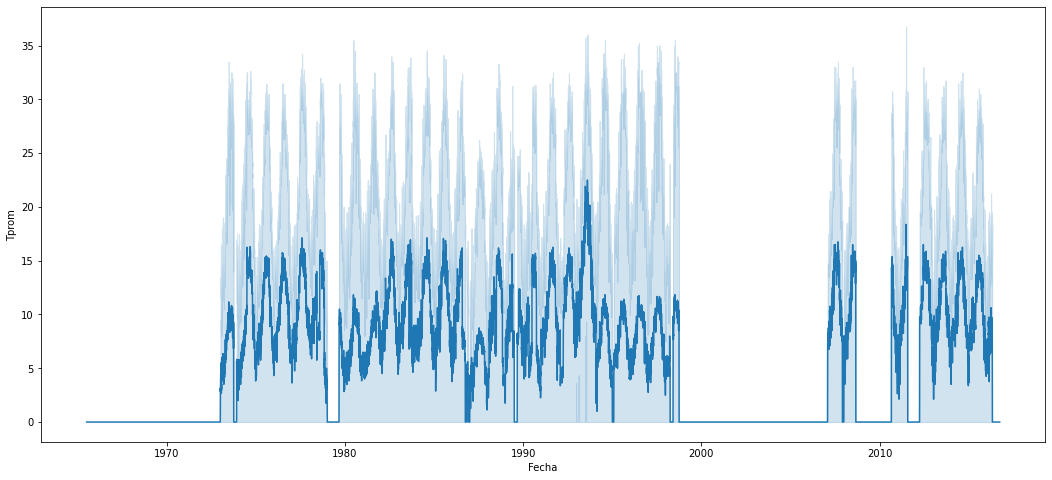

In [25]:
plt.figure(figsize=(18,8))
sns.lineplot(x = 'Fecha', y = 'Tprom', data = df)
plt.xlabel('Temperatura Promedio')

Text(0.5, 0, 'Temperatura Maxima')

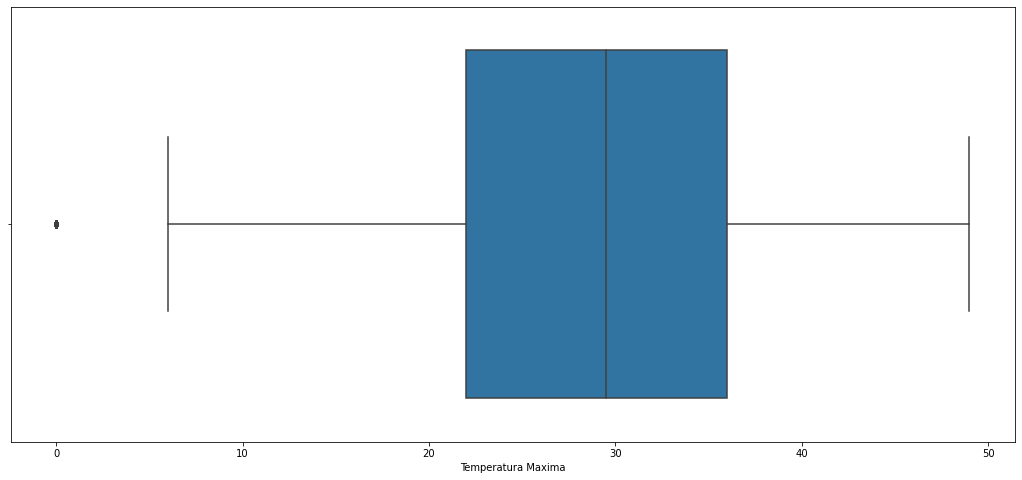

In [88]:
plt.figure(figsize = (18,8))
sns.boxplot(x=df.Tmax)
plt.xlabel('Temperatura Maxima')

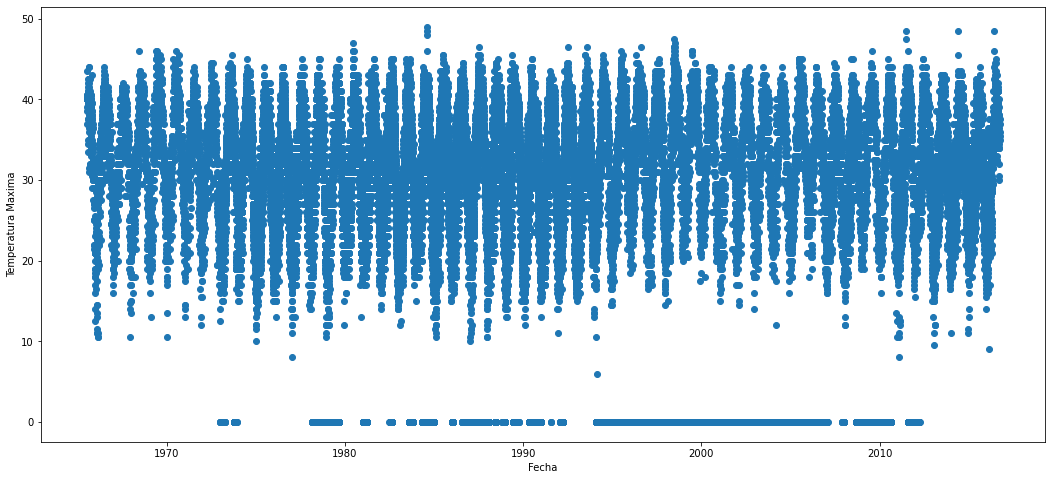

In [91]:
plt.figure(figsize = (18,8))
plt.scatter(df.Fecha, df.Tmax)
plt.xlabel('Fecha')
plt.ylabel('Temperatura Maxima');

In [ ]:
sns.pairplot(df, height= 2.5)

## Local Outlier Factor Method(LOF)

In [78]:
clf = LocalOutlierFactor(n_neighbors=1000, contamination='auto')
X = df[['Tmin', 'Tprom']].values
y_pred = clf.fit_predict(X)

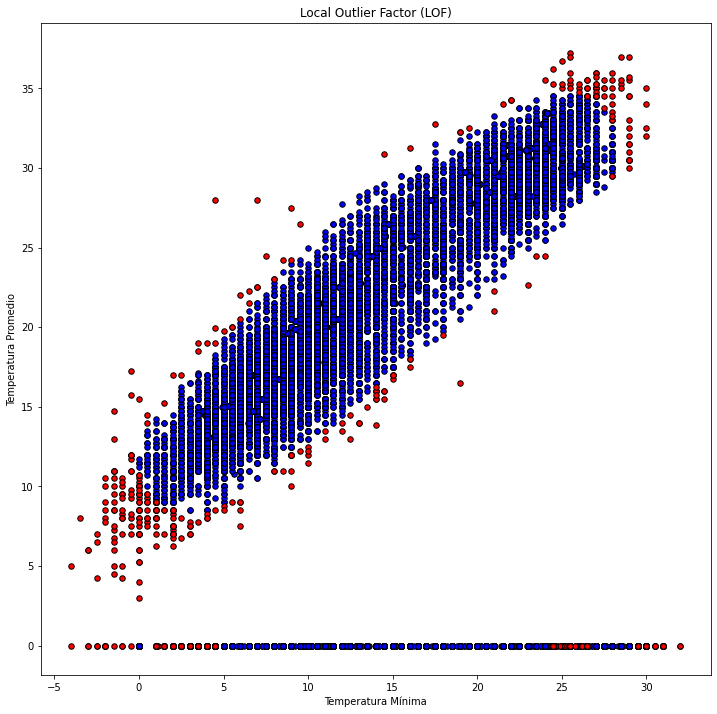

In [79]:
plt.figure(figsize=(12,12))
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
#plt.axis('Tprom')
plt.xlabel('Temperatura Mínima');
plt.ylabel('Temperatura Promedio');
plt.show()

## Z-Score

In [63]:
def out_zscore(data):
    global outliers,zscore
    outliers = []
    zscore = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in df:
        z_score= (i - mean)/std 
        zscore.append(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return print("Total number of outliers are",len(outliers))

In [66]:
out_zscore(df.Tprom)

TypeError: unsupported operand type(s) for -: 'str' and 'float'